In [ ]:
import pandas as pd
import lightgbm as lgb

In [ ]:
# 데이터 불러오기
train = pd.read_csv('/content/drive/MyDrive/movie/movies_train.csv')
test = pd.read_csv('/content/drive/MyDrive/movie/movies_test.csv')
submission = pd.read_csv('/content/drive/MyDrive/movie/submission.csv')

In [ ]:
train.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387


In [ ]:
test.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
0,용서는 없다,시네마서비스,느와르,2010-01-07,125,청소년 관람불가,김형준,3.005290e+05,2,304,3
1,아빠가 여자를 좋아해,(주)쇼박스,멜로/로맨스,2010-01-14,113,12세 관람가,이광재,3.427002e+05,4,275,3
2,하모니,CJ 엔터테인먼트,드라마,2010-01-28,115,12세 관람가,강대규,4.206611e+06,3,419,7
3,의형제,(주)쇼박스,액션,2010-02-04,116,15세 관람가,장훈,6.913420e+05,2,408,2
4,평행 이론,CJ 엔터테인먼트,공포,2010-02-18,110,15세 관람가,권호영,3.173800e+04,1,380,1


In [ ]:
submission.head()

,title,box_off_num
0,용서는 없다,0
1,아빠가 여자를 좋아해,0
2,하모니,0
3,의형제,0
4,평행 이론,0


In [ ]:
train.tail()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
595,해무,(주)NEW,드라마,2014-08-13,111,청소년 관람불가,심성보,3833.0,1,510,7,1475091
596,파파로티,(주)쇼박스,드라마,2013-03-14,127,15세 관람가,윤종찬,496061.0,1,286,6,1716438
597,살인의 강,(주)마운틴픽쳐스,공포,2010-09-30,99,청소년 관람불가,김대현,NaN,0,123,4,2475
598,악의 연대기,CJ 엔터테인먼트,느와르,2015-05-14,102,15세 관람가,백운학,NaN,0,431,4,2192525
599,베를린,CJ 엔터테인먼트,액션,2013-01-30,120,15세 관람가,류승완,NaN,0,363,5,7166532


In [ ]:
print(train.shape)
print(test.shape) # 영화 관객수 열이 제공되지 않음
print(submission.shape)

(600, 12)
(243, 11)
(243, 2)


In [ ]:
train.info()
# 7번은 모두 채워져 있지 않음 => 추후 전처리 필요

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           600 non-null    object 
 1   distributor     600 non-null    object 
 2   genre           600 non-null    object 
 3   release_time    600 non-null    object 
 4   time            600 non-null    int64  
 5   screening_rat   600 non-null    object 
 6   director        600 non-null    object 
 7   dir_prev_bfnum  270 non-null    float64
 8   dir_prev_num    600 non-null    int64  
 9   num_staff       600 non-null    int64  
 10  num_actor       600 non-null    int64  
 11  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 56.4+ KB


In [ ]:
test.info()
# 7번은 모두 채워져 있지 않음 => 추후 전처리 필요

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           243 non-null    object 
 1   distributor     243 non-null    object 
 2   genre           243 non-null    object 
 3   release_time    243 non-null    object 
 4   time            243 non-null    int64  
 5   screening_rat   243 non-null    object 
 6   director        243 non-null    object 
 7   dir_prev_bfnum  107 non-null    float64
 8   dir_prev_num    243 non-null    int64  
 9   num_staff       243 non-null    int64  
 10  num_actor       243 non-null    int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 21.0+ KB


In [ ]:
train.describe()
pd.options.display.float_format = '{:.1f}'.format

In [ ]:
# 장르별 관객 수 확인
train[['genre', 'box_off_num']].groupby('genre').mean().sort_values('box_off_num')

,box_off_num
genre,
뮤지컬,6627.0
다큐멘터리,67172.3
서스펜스,82611.0
애니메이션,181926.7
멜로/로맨스,425968.0
미스터리,527548.2
공포,590832.5
드라마,625689.8
코미디,1193914.0


In [ ]:
pd.reset_option('display.float_format')

In [ ]:
train.corr()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
time,1.000000,0.264675,0.306727,0.623205,0.114153,0.441452
dir_prev_bfnum,0.264675,1.000000,0.131822,0.323521,0.083818,0.283184
dir_prev_num,0.306727,0.131822,1.000000,0.450706,0.014006,0.259674
num_staff,0.623205,0.323521,0.450706,1.000000,0.077871,0.544265
num_actor,0.114153,0.083818,0.014006,0.077871,1.000000,0.111179
box_off_num,0.441452,0.283184,0.259674,0.544265,0.111179,1.000000


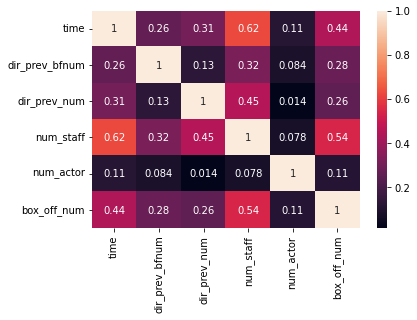

In [ ]:
import seaborn as sns
sns.heatmap(train.corr(), annot = True)
# box_off_num과 선형 관계가 깊은 것



In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='constant', fill_value= 0)
imputer.fit(train)
train.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387


In [ ]:
# 결측값 여부 확인 : pd.Series.isna()
# 결측치라면 True, 아니면 False
train.isna()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,False,False,False,False,False,False,False,True,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
595,False,False,False,False,False,False,False,False,False,False,False,False
596,False,False,False,False,False,False,False,False,False,False,False,False
597,False,False,False,False,False,False,False,True,False,False,False,False
598,False,False,False,False,False,False,False,True,False,False,False,False


In [ ]:
# 각 특성에 대하여 결측치의 개수를 보여줌
train.isna().sum()
# dir_prev_bfnum : 영화 감독이 해당 영화를 제작하기 전에 참여한 영화의 평균 관객 수

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    330
dir_prev_num        0
num_staff           0
num_actor           0
box_off_num         0
dtype: int64

In [ ]:
train[train['dir_prev_bfnum'].isna()] # 결측치가 있는 행 추출
# dir_prev_num : 감독이 해당 영화를 제작하기 전에 참여한 영화 수 = 0인 값이 결측치

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
6,길위에서,백두대간,다큐멘터리,2013-05-23,104,전체 관람가,이창재,NaN,0,32,5,53526
8,"1789, 바스티유의 연인들",유니버설픽쳐스인터내셔널코리아,뮤지컬,2014-09-18,129,전체 관람가,정성복,NaN,0,3,5,4778
9,청춘그루브,(주)두타연,드라마,2012-03-15,94,15세 관람가,변성현,NaN,0,138,3,868
10,AV 아이돌,(주) 케이알씨지,멜로/로맨스,2015-07-27,89,청소년 관람불가,조조 히데오,NaN,0,0,4,745
...,...,...,...,...,...,...,...,...,...,...,...,...
593,낭만파 남편의 편지,퍼스트런,미스터리,2013-09-12,97,청소년 관람불가,최위안,NaN,0,5,3,1132
594,오빠가 돌아왔다,(주)마운틴픽쳐스,코미디,2014-03-20,94,청소년 관람불가,노진수,NaN,0,37,5,1958
597,살인의 강,(주)마운틴픽쳐스,공포,2010-09-30,99,청소년 관람불가,김대현,NaN,0,123,4,2475
598,악의 연대기,CJ 엔터테인먼트,느와르,2015-05-14,102,15세 관람가,백운학,NaN,0,431,4,2192525


In [ ]:
train["dir_prev_bfnum"].fillna(0, inplace = True) # inplace = 저장까지 완료

In [ ]:
test["dir_prev_bfnum"].fillna(0, inplace = True)

# 모델

In [ ]:
# 순서대로 1000개의 모델 만들기 (이전 모델이 맞히지 못한 문제에 가중치)
model = lgb.LGBMRegressor(random_state=777, n_estimators=1000)

In [ ]:
# 상영 시간, 과거 제작 영화 수, 스태프 수, 배우 수
features = ['time', 'dir_prev_num', 'num_staff', 'num_actor']
target = ['box_off_num']

In [ ]:
X_train, X_test, y_train = train[features], test[features], train[target]

In [ ]:
model.fit(X_train, y_train)

LGBMRegressor(n_estimators=1000, random_state=777)

In [ ]:
singleLGBM = submission.copy()

In [ ]:
singleLGBM.head()

,title,box_off_num
0,용서는 없다,0
1,아빠가 여자를 좋아해,0
2,하모니,0
3,의형제,0
4,평행 이론,0


In [ ]:
singleLGBM['box_off_num'] = model.predict(X_test)

In [ ]:
singleLGBM.to_csv('singleLGBM.csv', index = False)

# k-fold 교차검증

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
k_fold = KFold(n_splits=5, shuffle = True, random_state= 777)

In [ ]:
model = lgb.LGBMRegressor(random_state=777, n_estimators=1000)

models = []
for train_idx, val_idx in k_fold.split(X_train):
  x_t = X_train.iloc[train_idx]
  y_t = y_train.iloc[train_idx]
  x_val = X_train.iloc[val_idx]
  y_val = y_train.iloc[val_idx]

  models.append(model.fit(x_t, y_t, eval_set=(x_val, y_val), early_stopping_rounds=100, verbose=100))

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 2.88521e+12
Early stopping, best iteration is:
[7]	valid_0's l2: 2.42024e+12
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 4.01909e+12
Early stopping, best iteration is:
[26]	valid_0's l2: 3.67535e+12
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 2.9793e+12
Early stopping, best iteration is:
[20]	valid_0's l2: 2.34645e+12
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 1.7188e+12
Early stopping, best iteration is:
[12]	valid_0's l2: 1.29919e+12
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 1.67975e+12
Early stopping, best iteration is:
[27]	valid_0's l2: 1.49504e+12


In [ ]:
preds = []
for model in models:
  preds.append(model.predict(X_test))
len(preds)

5

In [ ]:
kfoldLightGBM = submission.copy()

In [ ]:
import numpy as np

In [ ]:
kfoldLightGBM['box_off_num'] = np.mean(preds, axis = 0)

In [ ]:
kfoldLightGBM.to_csv('kfoldLightGBM.csv',index=False)

# Feature Engineering

In [ ]:
features

['time', 'dir_prev_num', 'num_staff', 'num_actor']

In [ ]:
train.columns

Index(['title', 'distributor', 'genre', 'release_time', 'time',
       'screening_rat', 'director', 'dir_prev_bfnum', 'dir_prev_num',
       'num_staff', 'num_actor', 'box_off_num'],
      dtype='object')

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
train['genre'] = le.fit_transform(train['genre'])

In [ ]:
train['genre']

0      10
1       2
2      10
3      11
4      11
       ..
595     4
596     4
597     1
598     2
599    10
Name: genre, Length: 600, dtype: int64

In [ ]:
test['genre'] = le.transform(test['genre'])

In [ ]:
features = ['time', 'dir_prev_num', 'num_staff', 'num_actor', 'dir_prev_bfnum', 'genre']


In [ ]:
X_train, X_test, y_train = train[features], test[features], train[target]

In [ ]:
model = lgb.LGBMRegressor(random_state=777, n_estimators=1000)

models = []
for train_idx, val_idx in k_fold.split(X_train):
  x_t = X_train.iloc[train_idx]
  y_t = y_train.iloc[train_idx]
  x_val = X_train.iloc[val_idx]
  y_val = y_train.iloc[val_idx]

  models.append(model.fit(x_t, y_t, eval_set=(x_val, y_val), early_stopping_rounds=100, verbose=100))

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 2.62067e+12
Early stopping, best iteration is:
[9]	valid_0's l2: 2.42668e+12
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 4.39227e+12
Early stopping, best iteration is:
[23]	valid_0's l2: 3.97173e+12
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 3.29841e+12
Early stopping, best iteration is:
[10]	valid_0's l2: 2.53643e+12
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 1.56499e+12
Early stopping, best iteration is:
[16]	valid_0's l2: 1.21201e+12
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 1.60118e+12
Early stopping, best iteration is:
[29]	valid_0's l2: 1.47528e+12


In [ ]:
preds = []
for model in models:
  preds.append(model.predict(X_test))
len(preds)

5

In [ ]:
feLightGBM = submission.copy()

In [ ]:
feLightGBM['box_off_numm'] = np.mean(preds, axis = 0)

In [ ]:
feLightGBM.to_csv('feLightGBM.csv', index = False)

# Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
model = lgb.LGBMRegressor(random_state=777, n_estimators=1000)

params = {
    'learning_rate' : [0.1, 0.01, 0.005, 0.003],
    'min_child_samples' : [20, 30, 50]}

gs = GridSearchCV(estimator=model,
                  param_grid=params,
                  scoring='neg_mean_squared_error',
                  cv=k_fold)

In [ ]:
gs.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=777, shuffle=True),
             estimator=LGBMRegressor(n_estimators=1000, random_state=777),
             param_grid={'learning_rate': [0.1, 0.01, 0.005, 0.003],
                         'min_child_samples': [20, 30, 50]},
             scoring='neg_mean_squared_error')

In [ ]:
gs.best_params_

{'learning_rate': 0.003, 'min_child_samples': 50}

In [ ]:
model = lgb.LGBMRegressor(n_estimators=1000, random_state=777, learning_rate = 0.003, min_child_samples=50)

models = []
for train_idx, val_idx in k_fold.split(X_train):
  x_t = X_train.iloc[train_idx]
  y_t = y_train.iloc[train_idx]
  x_val = X_train.iloc[val_idx]
  y_val = y_train.iloc[val_idx]

  models.append(model.fit(x_t, y_t, eval_set=(x_val, y_val), early_stopping_rounds=100, verbose=100))

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 2.487e+12
[200]	valid_0's l2: 2.31792e+12
[300]	valid_0's l2: 2.24401e+12
[400]	valid_0's l2: 2.22658e+12
[500]	valid_0's l2: 2.22884e+12
Early stopping, best iteration is:
[412]	valid_0's l2: 2.22594e+12
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 4.92631e+12
[200]	valid_0's l2: 4.47008e+12
[300]	valid_0's l2: 4.16419e+12
[400]	valid_0's l2: 3.9594e+12
[500]	valid_0's l2: 3.82147e+12
[600]	valid_0's l2: 3.72574e+12
[700]	valid_0's l2: 3.65965e+12
[800]	valid_0's l2: 3.61297e+12
[900]	valid_0's l2: 3.57952e+12
[1000]	valid_0's l2: 3.55934e+12
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 3.55934e+12
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 3.20675e+12
[200]	valid_0's l2: 2.87015e+12
[300]	valid_0's l2: 2.65403e+12
[400]	valid_0's l2: 2.52086e+12
[500]	valid_0's l2: 2.43976e+12
[600]	valid_0's l2: 2.389

In [ ]:
preds = []
for model in models:
  preds.append(model.predict(X_test))
len(preds)

5

In [ ]:
gs.best_score_

-2168532428226.2527

In [ ]:
gslgbm = submission.copy()

In [ ]:
gslgbm['box_off_num'] = np.mean(preds, axis = 0)

In [ ]:
gslgbm.to_csv('gslgbm.csv', index=False)